# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 


## Homework 9:  ANNs


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader<br/>


<hr style="height:2pt">



In [1]:
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Assumed Skills:
This assignment presumes knowledge of the following skills:
- Familiarity with sklearn's model objects
- Cross validation to estimate models' future performance
- Booststrapping to build alternative datasets
- Some instruction on Keras' interface for building and training neural networks

> These skills do not seem right 

<font color='blue'>Q1 
</font> <br/>
<font color='red'>This is not so great 
</font> <br/>


Import libraries:

In [2]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

import keras 
from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from keras import regularizers


from sklearn.utils import shuffle

Using TensorFlow backend.
/Users/pavlos/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


<hr style='height:2pt'>
<div class='theme'> Neural Networks </div> 

Neural networks are, of course, a large and complex topic that cannot be covered in a single homework. Here we'll focus on the key idea of NNs: they are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size). We'll also partially explore what patterns the neural network learns and how well they generalize.

In this question we'll see if Neural Networks can learn a (limited) version of the Fourier Transform. (The Fourier Transform takes in values from some function and returns a set of sine and cosine functions which, when added together, approximate the original function.)
> Give them the  general Fourier decomposition 

In our specific problem, we'll try to teach a network to map from  a function's 1000 sample y-values to the four features of the sine and cosine waves that make up that function. Thus, the network is attempting to learn a mapping from a 1000-entry vector down to a 4-entry vector. Our X_train dataset is thus N by 1000 and our y_train is N by 4. 
> Let's change the notation. y-values is the x_train ... 

We'll use 6 data files in this question:
- `sinewaves_X_train.npy` and `sinewaves_y_train.npy`: a (10,000 by 1,000) and (10,000 by 4) training dataset. Examples were generated by randomly selecting a,b,c,d in the interval [0,1] and building the curve $a\sin(b\,x) + c\cos(d\,x)$
- `sinewaves_X_test.npy` and `sinewaves_y_test.npy`: a (2,000 by 1,000) and (2,000 by 4) test dataset, generated in the same way as the training data
- `sinewaves_X_extended_test` and `sinewaves_y_extended_test`: a (9 by 1,000) and (9 by 4) test dataset, testing whether the network can generalize beyond the training data (e.g. to negative values of $a$)

**These datasets are read in to their respective variables for you.**

<div class='exercise'> <b> Question 1 [50pts] <b> </div>
**1.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve.

**1.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.24\sin(0.533\,x) + 0.018\cos(0.558\,x)$. This pattern (y_train is the true parameters of the curve in X_train) will always hold.

**1.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

**1.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

**1.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of 0.2. You can train for longer if you wish- the fit tends to improve over time.

**1.6** Use the `plot_predictions` function to plot the model's predictions on `X_test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefficients that generated the data?

**1.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

**1.8** Is there something that stands out about the difficult examples, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

**Hint**:
- Keras's documentation and examples of a Sequential model are a good place to start.
- A strong model can achieve validation error of around 0.03 on this data and 0.02 is very good.

In [3]:
def plot_predictions(model, test_x, test_y, count=None):
    # Model - a Keras or SKlearn model that takes in (n,1000) training data and predicts (n,4) output data
    # test_x - a (n,1000) input dataset
    # test_y - a (n,4) output dataset
    # This function will plot the sine curves in the training data and those implied by the model's predictions.
    # It will also print the predicted and actual output values.
    
    #helper function that takes the n by 4 output and reverse-engineers 
    #the sine curves that output would create
    def y2x(y_data):
        #extract parameters
        a=y_data[:,0].reshape(-1,1)
        b=y_data[:,1].reshape(-1,1)
        c=y_data[:,2].reshape(-1,1)
        d=y_data[:,3].reshape(-1,1)

        #build the matching training data
        x_points = np.linspace(0,10*np.pi,1000)
        x_data = a*np.sin(np.outer(b,x_points)) + c*np.cos(np.outer(d,x_points))
        return x_data
    
    #if <20 examples, plot all. If more, just plot 5
    if count==None:
        if test_x.shape[0]>20:
            count=5
        else:
            count=test_x.shape[0]
    
    #build predictions
    predicted = model.predict(test_x)
    implied_x = y2x(predicted)
    for i in range(count):
        plt.plot(test_x[i,:],label='true')
        plt.plot(implied_x[i,:],label='predicted')
        plt.legend()
        plt.ylim(-2.1,2.1)
        plt.xlabel("x value")
        plt.xlabel("y value")
        plt.title("Curves using the Neural Network's Approximate Fourier Transform")
        plt.show()
        print("true:", test_y[i,:])
        print("predicted:", predicted[i,:])
    
    

In [4]:
X_train = np.load('data/sinewaves_X_train.npy')
y_train = np.load('data/sinewaves_y_train.npy')

X_test = np.load('data/sinewaves_X_test.npy')
y_test = np.load('data/sinewaves_y_test.npy')

X_extended_test = np.load('data/sinewaves_X_extended_test.npy')
y_extended_test = np.load('data/sinewaves_y_extended_test.npy')

### Answers:  

**1.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

In [5]:
# your code here

**1.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced points in $[0,10\pi]$ from the function $f(x) = 0.24\sin(0.533\,x) + 0.018\cos(0.558\,x)$...

In [6]:
# your code here

**1.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

In [7]:
# your code here

**1.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

In [8]:
# your code here

----
Your answer here

----

**1.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of .2. You can train for longer if you wish- the fit tends to improve over time.

In [9]:
# your code here

**1.6** Use the `plot_predictions` function to plot the model's predictions on `X-test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?

In [10]:
# your code here

----
Your answer here

----

**1.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

In [11]:
# your code here

----
Your answer here

----

**1.8** Is there something that stands out about the difficult observations, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

----
Your answer here

----

<hr style='height:2pt'>

## Neural Networks ... the good, the bad, and the ugly

In this problem set we have already explored how ANN are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size), and additionally we also partially explore what patterns the neural network learns and how well they generalize. Now, in this problem we will work towards developing an Artificial Neural Network Classifier for image recognition. Our goal is to delve into exploring the good, the bad and the ugly of ANNs. 

As we have explained in class, an issue present during ANN learning is overfitting, where we have small training errors and as test data and new data is handed to the neural network the error is large. This is the classic overfitting situation where, in this case the ANN has been able to learn in specificity the patterns present in the training data, however it is unable to learn as to how to generalize that same learning to new data.    

There are several methods used to improve ANN generalization. One approach is to concentrate in goodness of fit by devising an ANN architecture that is just large enough width-wise and depth-wise to yield an efficient fit. The point to consider here is that the larger the network, the higher level of complexity is thereby introduced into the network as the ANN can create more complex functions. Thus, with a smaller network, the lesser level of complexity that is introduced into the modeling and learning procedure.

However, it is not straightforward and difficult to know a priori the size of the ANN. Given this, other methodologies are used to fight overfitting and improve the ANN pattern-generalization ability, which fall under the umbrella of Regularization.

As covered in lecture, Regularization is any modification we make to a learning algorithm that is strictly oriented to reduce the generalization error but not the training error.

In this problem you are asked to regularize a network given to you below. The train dataset can be generated using the code also given below. 


> Caveat: 
This is a toy model designed such as fitting is quick. Certain choises are certainly not best practices but for the sake of simplicity and being able to complete the homework in reasonable time we made some compromises/ 
1. We use sigmoid as the activation function. Though we advised you not to use sigmoid, in this homework we ask you to use the sigmoid activation function. ReLU is a better choice for deeper netwroks but here sigmoid works faster and it is more stable for this small dataset.  
 



<div class='exercise'> <b> Question 2 [50 pts] </b> </div>


**2.1** ** Data Download and Exploration**:  For this problem, we will be working with the MNIST dataset (Modified National Institute of Standards and Technology database) which is a large database of handwritten digits and commonly used for training various image processing systems. We will be working directly with the download from `keras MNIST dataset` of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.


Please refer to the `keras` documentation and download the MNIST dataset for usage and pay close attention to the data structure it returns. 

For pedagogical reasons, we will only use the digits labeled `4` and `9`, and we want to use a total of 800 samples for training. 

Create this binary class problem.

**2.2 Overfit an ANN:** Build a fully connected network (FCN) using `keras`: 

1. Number of layers: 1
2. Number of nodes per layer: 500 
3. Activation function: Sigmoid (yes sigmoid) 
4. Loss function: binary_crossentropy
5. Output unit: Sigmoid 
6. Optimizer: sgd
7. Epochs: 500
8. Batch size: 128

This NN trained on the dataset you built in 2.1 will overfit to the training set. Plot the training accuracy and validation accuracy as a function of epochs and confirm that it overfits. 

**2.3 Explore Regularization**: Your task is to regularized this FCN. You are free to explore any method or combination of methods. If you are using anything besides the methods we have covered in class, give a citation and a short explanation. You should always have an understanding of the methods you are using. 

Save the model using `model.save(filename)` and submit in canvas along with your notebook. 

We will evaluate your model on a test set we kept secret. 

1. Do not use extra data from NMIST. We will run your notebook and validate your model on the training set. 
2. Keep the  architecture above as is. In other words keep the number of layers, number of nodes, activation function , loss fucntion the same. You can change the number of epochs, batch size, optimizer and of course add elements that can help to regularize (e.g. drop out, L2 norm etc). You can also do data augmentation. 


Improvement on the test score:
1.  (0-1] percent will result into 10 pts
2.  (1-2] percent will result into 20 pts
3.  (2-3] percent will result into 30 pts
4.  (3 and above percent will result in 40 pts
6.   Top 15 groups or single students will be awarded  an additional 5 pts
7.   Winner(s) will be awarded an additional point 10 pts

**2.1** ** Data Download and Exploration**:  For this problem, we will be working with the MNIST dataset (Modified National Institute of Standards and Technology database) which is a large database of handwritten digits and commonly used for training various image processing systems. We will be working directly with the download from `keras MNIST dataset` of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.


Please refer to the `keras` documentation and download the MNIST dataset for usage and pay close attention to the data structure it returns. 

For pedagogical reasons, we will only use the digits labeled `4` and `9`, and we want to learn the ANN with a total of 800 samples and we will use 800 for test set. Now make sure you make this a binary class problem.

In [71]:
# SHALL WE GIVE THEM THIS? 

## Read and Setup train and test splits in one
from keras.datasets import mnist 
from random import randint 

(x_train, y_train), (x_test, y_test) = mnist.load_data() 

#shuffle the data before we do anything
x_train, y_train = shuffle(x_train, y_train, random_state=1)

## Making a copy before flattening 
x_train_drawing = x_train
y_train_or = y_train


## separating 4s and 9s
class1 = 4
class2 = 9
idx_tr  = (y_train == class1) | (y_train==class2)
idx_te  = (y_test == class1) | (y_test==class2)

## building the train and test set needed by 4s and 9s

x_train= x_train[idx_tr, :, :]
x_test= x_test[idx_te, :, :] 
y_train= y_train[idx_tr]
y_test= y_test[idx_te] 


## randomly select 800 points 
n_train = 800
n_test = 800 

x_train= x_train[:n_train, :, :]
x_test= x_test[:n_test, :, :]
y_train= y_train[:n_train]
y_test= y_test[:n_test]


## making it a binary class problem
y_train[y_train==class1] = 0 
y_train[y_train==class2] = 1
y_test[y_test==class1] = 0 
y_test[y_test==class2] = 1 




**2.2** Now that we have downloaded the images and split our training and test datasets, and created the simple binary dataset, we still need to preprocess the images in order to use them. Preprocessing needs to be performed on the feature space and the labels (response) independently. 

In [72]:
# your code here


num_classes = 2 

## flatten images
image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) 
x_test = x_test.reshape(x_test.shape[0], image_size)

## Convertion class vectors ---> binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [77]:
x_train = ((x_train-x_train.mean(axis=1).reshape(-1,1))/(x_train.std(axis=1).reshape(-1,1)))
x_test = ((x_test-x_test.mean(axis=1).reshape(-1,1))/(x_test.std(axis=1).reshape(-1,1)))

**2.3** Look at the data randomly, and perform any other sanity checks you deem necessary. 

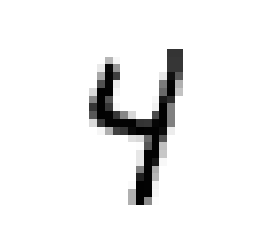

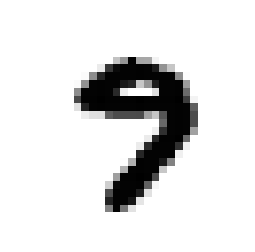

In [78]:
# your code here

x_train.shape, x_test.shape, y_train.shape, y_test.shape

plt.axis('off')
plt.imshow(x_train.reshape(-1, 28,28)[2], cmap='Greys')
plt.show()
plt.axis('off')
plt.imshow(x_train.reshape(-1, 28,28)[1], cmap='Greys')

**2.4 Overfit an ANN:** For this portion of the problem we want you to create a network using `keras` that overfits this dataset. Follow the explanation in the initial problem statement, and make sure the network OVERFITS. Explain what you see in your network output.

Hint: 
1. We use n_layes>=2, n_nodes>=100, activation = reLU 
2. Use 0.5 validation split to ensure your validation and train difference is well established 




In [96]:
# your code here

batch_size = 32
epochs = 100

num_classes = 2 

nodes_layers =[100,100,100] 

#reset the model 
model = Sequential()

# input layers 
model.add(Dense(nodes_layers[0], activation='relu', input_shape=(784,)))

# hidden layers 
for s in nodes_layers[1:]:
        model.add(Dense(units = s,  activation = 'relu'))

# output layer 
model.add(Dense(units=num_classes,  activation='sigmoid'))


# Summary 
#model.summary()

# compile it 
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])

# fit it 

history_basic = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,  validation_split=.5, verbose=False)#False

#save the model 


800/800 [==============================] - 0s 56us/step


[3.9486803436279296, 0.94374999999999998]

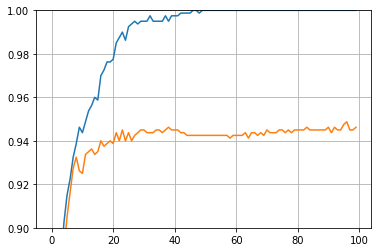

In [108]:
plt.plot(history_basic.history['acc'])
plt.plot(history_basic.history['val_acc'])
plt.grid()
plt.ylim((0.9,1))
model.evaluate(x_test, y_test)

<hr>

Your answer here

<hr>

In [118]:
# your code here

### L2 and L1 

eta = 0.07

#reset the model 
model = Sequential()

# input layers 
model.add(Dense(nodes_layers[0], activation='relu', input_shape=(784,), kernel_regularizer=regularizers.l2(eta)))

# hidden layers 
for s in nodes_layers[1:]:
        model.add(Dense(units = s,  activation = 'relu', kernel_regularizer=regularizers.l2(eta)))

# output layer 
model.add(Dense(units=num_classes,  activation='sigmoid'))


# Summary 
#model.summary()

# compile it 
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# fit it 

history_l2 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,  validation_split=.5, verbose=False)#False



800/800 [==============================] - 0s 45us/step


[1.9982918739318847, 0.953125]

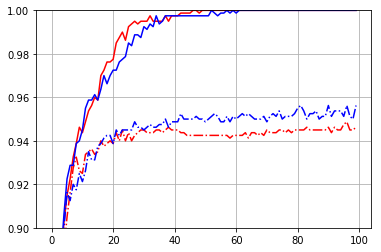

In [117]:
plt.plot(history_basic.history['acc'], 'r-')
plt.plot(history_basic.history['val_acc'], 'r-.')

plt.plot(history_l2.history['acc'], 'b-')
plt.plot(history_l2.history['val_acc'], 'b-.')
plt.ylim((0.9, 1))
plt.grid()

model.evaluate(x_test, y_test)

In [100]:
# your code here

### Early stopping

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                              patience=0, verbose=0, mode='auto')




#reset the model 
model = Sequential()

# input layers 
model.add(Dense(nodes_layers[0], activation='relu', input_shape=(784,)))

# hidden layers 
for s in nodes_layers[1:]:
        model.add(Dense(units = s,  activation = 'relu'))


# output layer 
model.add(Dense(units=num_classes,  activation='sigmoid'))


# Summary 
#model.summary()

# compile it 
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# fit it 

history_es = model.fit(x_train, y_train, batch_size=batch_size, callbacks=[earlyStopping], epochs=epochs,  validation_split=.5, verbose=False)#False



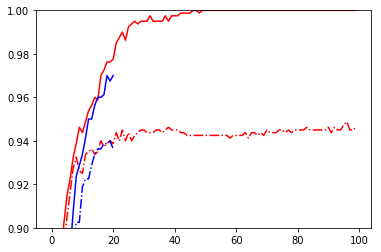

In [103]:
plt.plot(history_basic.history['acc'], 'r-')
plt.plot(history_basic.history['val_acc'], 'r-.')

plt.ylim((0.9, 1))
plt.plot(history_es.history['acc'], 'b-')
plt.plot(history_es.history['val_acc'], 'b-.')